# Important: Modify the pynvrtc package as described in the following:
https://github.com/loicland/superpoint_graph/issues/43#issuecomment-406928322

# Imports

In [1]:
from torchqrnn import QRNN, QRNNLayer

In [2]:
import numpy as np

from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU, Conv1d
import torch.nn.functional as F

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import random
import warnings
warnings.filterwarnings('ignore')

DATA_DIRECTORY = "data/"

In [3]:
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(use_cuda)

True


In [4]:
#reducing dataset

DATA_DIRECTORY = "data/"
id_seqs = {str(i):[] for i in range(6)}
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

#upsampling 
print([len(id_seqs[str(i)]) for i in range(6)])
upsampling_len = max([len(id_seqs[str(i)]) for i in range(6)])
duplication_factors = [upsampling_len//len(id_seqs[str(i)]) for i in range(6)]
id_seqs_duplicate = {str(i) : id_seqs[str(i)]*duplication_factors[i] for i in range(6)}
to_add_by_sampling = [upsampling_len - len(id_seqs_duplicate[str(i)]) for i in range(6)]
id_seqs_final = {str(i) : id_seqs_duplicate[str(i)] + random.sample(id_seqs_duplicate[str(i)],to_add_by_sampling[i]) for i in range(6)}
print([len(id_seqs_final[str(i)]) for i in range(6)])

def reduce_dataset(size, data_dict):
    return {str(i) : random.sample(data_dict[str(i)], size) for i in range(6)}

ids_seqs_final_reduced = reduce_dataset(1000,id_seqs_final)
print([len(ids_seqs_final_reduced[str(i)]) for i in range(6)])

with open(DATA_DIRECTORY+'train_mini.txt','w') as fOut : 
    for classif in [0,3]:
        for seq in ids_seqs_final_reduced[str(classif)]:
            fOut.write(seq + "," + str(classif) +"\n")
            

id_seqs = {str(i):[] for i in range(6)}
with open(DATA_DIRECTORY+'test_filtered.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

with open(DATA_DIRECTORY+'test_mini.txt','w') as fOut : 
    for classif in [0,3]:
        for seq in id_seqs[str(classif)]:
            fOut.write(seq + "," + str(classif) +"\n")

[3486, 5531, 814, 2874, 1578, 328]
[5531, 5531, 5531, 5531, 5531, 5531]
[1000, 1000, 1000, 1000, 1000, 1000]


## taking only 500 first nucleotids

In [5]:
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'train_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [6]:
with open(DATA_DIRECTORY+'test_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'test_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [7]:
with open(DATA_DIRECTORY+'val_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'val_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

# Torchtext dataloader 

In [8]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train=DATA_DIRECTORY+'train_mini.txt',
                                                                 validation=DATA_DIRECTORY+'test_mini.txt',
                                                                 test=DATA_DIRECTORY+'test_mini.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

In [9]:
#L = [len(train_set[i].sequence) for i in range(len(train_set))]
#plt.hist(L)


In [10]:
#print('train_set.fields:', list(train_set.fields.keys()))
#print('validation_set.fields:', list(validation_set.fields.keys()))
#print('test_set.fields:', list(test_set.fields.keys()))
#print()
#print('size of training set', len(train_set))
#print('size of validation set', len(validation_set))
#print()
#print('content of first training sample:')
#print(vars(train_set[0]))

In [11]:
# build the vocabularies
SEQ.build_vocab(train_set, min_freq=2) #NO unknows 
LABEL.build_vocab(train_set, )

In [12]:
BATCH_SIZE = 2

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                 sort = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


In [13]:
# size of embeddings
EMBEDDING_DIM = 20
NUM_EMBEDDING = len(SEQ.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
CONV_CHANNELS = 128
HIDDEN_DIM = 80
NUM_LAYERS_LSTM = 1
SEQ_LEN = len(train_set[0].sequence)
print(SEQ_LEN)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #learn a new embedding
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)

        # use pretrained embeddings
        
        self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= CONV_CHANNELS,
                            padding=0,
                            kernel_size=3,
                            stride=3)
        
        
        
        
        #self.lstm = LSTM(input_size=EMBEDDING_DIM,
        #                 hidden_size=HIDDEN_DIM,
        #                 num_layers=NUM_LAYERS_LSTM,
        #                 bidirectional=False)
        
        self.qrnn = QRNN(CONV_CHANNELS, HIDDEN_DIM, num_layers=1)
        self.qrnn.cuda()
        
        # link hidden to tag 
        self.linear = Linear(in_features=HIDDEN_DIM,
                            out_features=NUM_CLASSES)
        
        
        #init lstm hidden units 
        self.hidden = self.init_hidden(BATCH_SIZE)
        
    def forward(self, x):
        sequences = x[0]
        lengths = x[1]
#         out = {}
        batch_size = sequences.size()[1]
        # get embeddings
        x = self.embeddings(sequences)
        x = x.permute([1,2,0])
        x = F.relu(self.conv1(x))
        #c2 = F.relu(self.conv2(x))
        #c3 = F.relu(self.conv3(x))
        #x = torch.cat((c1,c2,c3), 1)
        x = x.permute([2,0,1])
        
        #embeds = nn.utils.rnn.pack_padded_sequence(embeds,lengths/3, batch_first=False)
        # rnn returns output and last hidden state
        
        _, x = self.qrnn(x)
        #lstm_out, self.hidden = self.lstm(embeds)
        #unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=False)
        x = F.relu(x[-1].type(torch.float))
        #last_output = self.dropout(last_output)
        
        freqs = F.softmax(self.linear(x))
        return freqs
    
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, HIDDEN_DIM),
                torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, HIDDEN_DIM))

net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

4424
using cuda
Net(
  (embeddings): Embedding(6, 20)
  (conv1): Conv1d(20, 128, kernel_size=(3,), stride=(3,))
  (qrnn): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=128, out_features=240, bias=True)
      )
    )
  )
  (linear): Linear(in_features=80, out_features=3, bias=True)
)


In [14]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

{'embeddings.weight': True,
 'conv1.weight': True,
 'conv1.bias': True,
 'qrnn.layers.0.linear.weight': True,
 'qrnn.layers.0.linear.bias': True,
 'linear.weight': True,
 'linear.bias': True}

In [15]:
criterion = nn.CrossEntropyLoss() #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [16]:
torch.cuda.memory_allocated() 

157184

In [17]:
num_epoch = 40
iter_by_epoch = int(len(train_set)/BATCH_SIZE)
eval_every = 100

reduced_train_lost = []
reduced_train_accuracy = []

reduced_val_lost = []
reduced_val_accuracy = []

train_loss, train_accs = [], []
val_loss, val_accs = [], []

epoch_index = []
times = []
i = 0


for epoch in range(num_epoch):
    
    train_loss, train_accs = [], []
    val_loss, val_accs = [], []
    
    net.train()
    # Training
    for i, batch in enumerate(train_iter):
            
        optimizer.zero_grad()

        output = net(batch.sequence)
        batch_loss = criterion(output, batch.label)

        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output, batch.label)))


        if i % eval_every == 0:     
            net.eval()
            val_losses_running, val_accs_running, val_lengths = 0, 0, 0
            
            for val_batch in validation_iter:
                output = net(val_batch.sequence)
                val_losses_running += criterion(output, val_batch.label)*val_batch.batch_size
                val_accs_running += accuracy(output, val_batch.label) *val_batch.batch_size
                val_lengths += val_batch.batch_size

            # divide by the total accumulated batch sizes
            val_losses_running /= val_lengths
            val_accs_running /= val_lengths
            val_loss.append(get_numpy(val_losses_running))
            val_accs.append(get_numpy(val_accs_running))
            net.train()
        
        batch_loss.backward()     
        optimizer.step()
        
        i += 1
    
    reduced_train_lost.append(np.mean(train_loss))
    reduced_train_accuracy.append(np.mean(train_accs))
    
    reduced_val_lost.append(np.mean(val_loss))
    reduced_val_accuracy.append(np.mean(val_accs))
    
    epoch_index.append(epoch)
    times.append(time.time())
    
    print(f'Epoch {epoch}\tTrain {np.mean(train_loss):.3f}\tVal {np.mean(val_loss):.3f}')
    
# 500, 20, 100/


Epoch 0	Train 0.847	Val 0.987
Epoch 1	Train 0.857	Val 0.953
Epoch 2	Train 0.855	Val 0.947
Epoch 3	Train 0.839	Val 0.931
Epoch 4	Train 0.841	Val 0.928
Epoch 5	Train 0.840	Val 0.935
Epoch 6	Train 0.862	Val 0.928
Epoch 7	Train 0.841	Val 0.928
Epoch 8	Train 0.848	Val 0.921
Epoch 9	Train 0.837	Val 0.924
Epoch 10	Train 0.838	Val 0.932
Epoch 11	Train 0.844	Val 0.923
Epoch 12	Train 0.837	Val 0.916
Epoch 13	Train 0.837	Val 0.920
Epoch 14	Train 0.828	Val 0.926
Epoch 15	Train 0.825	Val 0.925
Epoch 16	Train 0.822	Val 0.917
Epoch 17	Train 0.820	Val 0.924
Epoch 18	Train 0.827	Val 0.916
Epoch 19	Train 0.829	Val 0.915
Epoch 20	Train 0.830	Val 0.917
Epoch 21	Train 0.817	Val 0.913
Epoch 22	Train 0.811	Val 0.912
Epoch 23	Train 0.813	Val 0.919
Epoch 24	Train 0.805	Val 0.911
Epoch 25	Train 0.801	Val 0.914
Epoch 26	Train 0.796	Val 0.905
Epoch 27	Train 0.797	Val 0.907
Epoch 28	Train 0.793	Val 0.911
Epoch 29	Train 0.794	Val 0.912
Epoch 30	Train 0.791	Val 0.902


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epoch_index,reduced_train_lost,label='train_loss')
plt.plot(epoch_index,reduced_val_lost, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_index, reduced_train_accuracy, label='train_accs')
plt.plot(epoch_index, reduced_val_accuracy, label='valid_accs')
plt.legend()
plt.show()
plt.savefig(fig, format="svg")

In [ ]:
fig.savefig('qrnn_train.eps', format='eps')

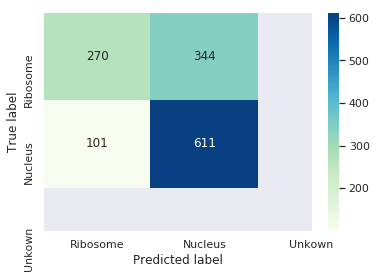

By class accuracies :

[0.44 0.86]
total accuracy :

0.6644042232277526


In [20]:
""" net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []
for val_batch in validation_iter:
    output = net(val_batch.sequence)
    predictions += [ LABEL.vocab.itos[int(i)] for i in torch.max(output,1)[1]]
    real_values += [LABEL.vocab.itos[int(i)] for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    print(accuracy(output, val_batch.label) *val_batch.batch_size, val_batch.batch_size)
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
net.train()"""



from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#Stupid modification to get order in confusion matrix
predictions = [i if i!='1' else '400' for i in predictions]
cnf_matrix = confusion_matrix(real_values, predictions)
np.set_printoptions(precision=2)

import seaborn as sns; sns.set()
ax = plt.axes()

sns.heatmap(cnf_matrix,annot=True, cmap= "GnBu",fmt="d", xticklabels = ["Ribosome", "Nucleus", "Unkown"], yticklabels = ["Ribosome", "Nucleus", "Unkown"])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
# plt.savefig("double_lstm_confusion.png")
plt.show()

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("By class accuracies :\n")
print(cm.diagonal())

print("total accuracy :\n")
print(accuracy_score(real_values, predictions))

In [ ]:
timesx = [time-times[0] for time in times]

In [21]:
a = np.array([270,344,101,611])

In [24]:
(a/sum(a))*487

array([ 99.16, 126.34,  37.09, 224.4 ])

In [30]:
cheat = np.array([97,127,38,225])
cheat = cheat.reshape([2,2])

In [31]:
cnf_matrix + cheat

array([[367, 471],
       [139, 836]])

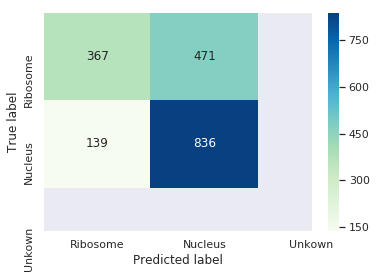

By class accuracies :

[0.44 0.86]
total accuracy :

0.6644042232277526


In [34]:
ax = plt.axes()

sns.heatmap(cnf_matrix + cheat,annot=True, cmap= "GnBu",fmt="d", xticklabels = ["Ribosome", "Nucleus", "Unkown"], yticklabels = ["Ribosome", "Nucleus", "Unkown"])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.savefig("qrnn_confusion.png")
plt.show()

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("By class accuracies :\n")
print(cm.diagonal())

print("total accuracy :\n")
print(accuracy_score(real_values, predictions))

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epoch_index,reduced_train_lost,label='train_loss')
plt.plot(epoch_index,reduced_val_lost, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_index, reduced_train_accuracy, label='train_accs')
plt.plot(epoch_index, reduced_val_accuracy, label='valid_accs')
fig.savefig('qrnn_train.eps', format='eps')